In [1]:
import os

from matplotlib import pyplot as plt
import pandas as pd

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_rna_expression_data,
                          load_seq_comparison_data)
from plotting import (isoform_box_and_line_drawing,
                      y2h_ppi_per_tf_gene_plot,
                      y1h_pdi_per_tf_gene_plot,
                      m1h_activation_per_tf_gene_plot)

In [2]:
y2h = load_isoform_and_paralog_y2h_data(add_missing_data=True)
y1h = load_y1h_pdi_data(add_missing_data=True)
m1h = load_m1h_activation_data(add_missing_data=True)
# rna = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
#idents = load_seq_comparison_data()

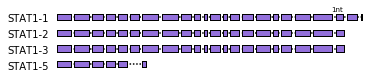

In [3]:
gene_name = 'STAT1'
isoform_box_and_line_drawing('STAT1',
                             isoforms.loc[isoforms['gene'] == gene_name, 'clone_acc'].values)

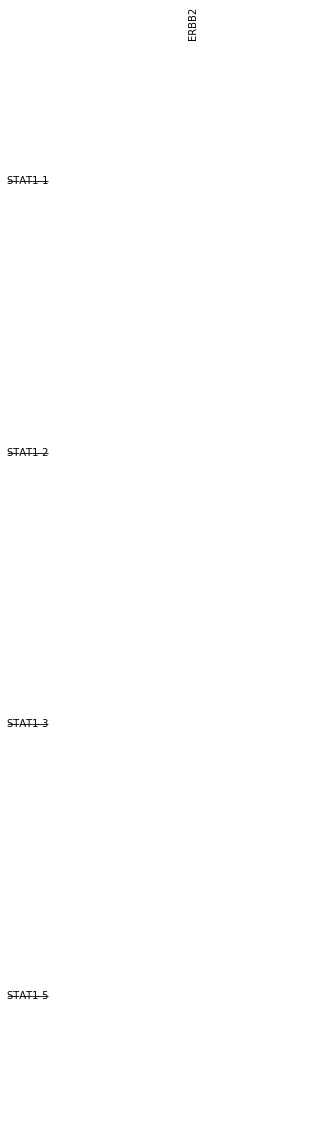

In [4]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
gene_name = 'STAT1'
y2h_ppi_per_tf_gene_plot(gene_name, data=y2h)

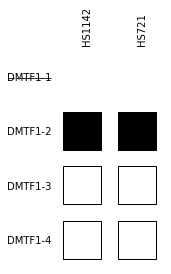

In [5]:
y1h_pdi_per_tf_gene_plot('DMTF1', y1h)

In [6]:
def tf_gene_summary_plot(gene_name):
    """
    

    """
    n_iso_y2h = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['ad_gene_symbol'] == gene_name),
                        'ad_clone_acc'].nunique()
    n_partner_y2h = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                            (y2h['ad_gene_symbol'] == gene_name),
                            'db_gene_symbol'].nunique()
    n_iso_y1h = (y1h['tf'] == gene_name).sum()
    n_partner_y1h = y1h.loc[(y1h['tf'] == gene_name), y1h.columns[2:]].any(axis=0).sum()
    fig, axes = plt.subplots(4, 1)
    fig.set_size_inches(max(7, n_partner_y2h * 0.2, n_partner_y2h * 0.2),
                        max(20, n_iso_y2h * 0.2, n_iso_y1h * 0.2))
    
    isoform_box_and_line_drawing(gene_name,
                                 isoforms.loc[isoforms['gene'] == gene_name, 'clone_acc'].values,
                                 ax=axes[0])
    y2h_ppi_per_tf_gene_plot(gene_name, data=y2h, ax=axes[1])
    y1h_pdi_per_tf_gene_plot(gene_name, data=y1h, ax=axes[2])
    m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=axes[3])
    os.makedirs('../../figures/per_tf_gene', exist_ok=True)
    plt.savefig('../../figures/per_tf_gene/' + gene_name + '_summary.pdf',
                bbox_inches='tight')
    plt.close(fig)


for gene in isoforms['gene'].unique():
    tf_gene_summary_plot(gene)